In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [29]:
!kaggle datasets download -d mdmahadihasan007/rv-dataset

Dataset URL: https://www.kaggle.com/datasets/mdmahadihasan007/rv-dataset
License(s): unknown
rv-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
import zipfile
zip_ref = zipfile.ZipFile("/content/rv-dataset.zip")
zip_ref.extractall('/content')
zip_ref.close()

In [31]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [32]:
# Device ready
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Ready

In [33]:
from pathlib import Path
image_path = Path("/content/train_and_test")
image_path

PosixPath('/content/train_and_test')

In [34]:
# Train and test directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/train_and_test/train'),
 PosixPath('/content/train_and_test/test'))

In [35]:
num_classes = 20

## ViT model

In [36]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [37]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [38]:
model = torchvision.models.vit_b_16(weights = weights)

In [39]:
# Freeze all layers in model
for param in model.parameters():
  param.requires_grad = False

In [40]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [41]:
!pip install torchinfo

In [42]:
!pip install torchinfo

from torchinfo import summary
summary(
    model = model,
    input_size = (1, 3, 224, 224),
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

In [43]:
torch.manual_seed(42)

model.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features = 768, out_features = num_classes)
)

In [44]:
summary(
    model = model,
    input_size = (1, 3, 224, 224),
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 20]              768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Setup DataLoader

In [45]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [46]:
# Create dataset
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = auto_transforms)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = auto_transforms)

In [47]:
class_names = train_data.classes
class_names

['10_Lal_Aush',
 '11_Jirashail',
 '12_Gutisharna',
 '13_Red_Cargo',
 '14_Najirshail',
 '15_Katari_Polao',
 '16_Lal_Biroi',
 '17_Chinigura_Polao',
 '18_Amon',
 '19_Shorna5',
 '1_Subol_Lota',
 '20_Lal_Binni',
 '2_Bashmoti',
 '3_Ganjiya',
 '4_Shampakatari',
 '5_Katarivog',
 '6_BR28',
 '7_BR29',
 '8_Paijam',
 '9_Bashful']

In [48]:
# Turn images into data loaders
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 64,
                              shuffle = True,
                              num_workers = 0,
                              pin_memory = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 64,
                             shuffle = False,
                             num_workers = 0,
                             pin_memory = True)

### Train Step function

In [49]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               device : torch.device) -> Tuple[float, float]:


    # Train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (x_train,y_train) in enumerate(tqdm(dataloader)):
        x_train, y_train = x_train.to(device), y_train.to(device)

        # Forward pass
        y_pred = model(x_train) # logist

        # loss
        loss = loss_fn(y_pred,y_train)
        train_loss += loss.item()

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

        # calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1),dim = 1)
        train_acc += (y_pred_class == y_train).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


### Test step function

In [50]:
def test_step(model : torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              device : torch.device) -> Tuple[float, float]:

    # Eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for batch, (x_test,y_test) in enumerate(dataloader):
            x_test, y_test = x_test.to(device), y_test.to(device)

            # Forward pass
            test_pred = model(x_test)

            # loss
            loss = loss_fn(test_pred, y_test)
            test_loss += loss.item()

            # calculate accuracy
            test_pred_labels = test_pred.argmax(dim = 1)
            test_acc += (test_pred_labels == y_test).sum().item() / len(test_pred_labels)


    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc


## Train

In [51]:

def train(model : torch.nn.Module,
          train_dataloader : torch.utils.data.DataLoader,
          test_dataloader : torch.utils.data.DataLoader,
          optimizer : torch.optim.Optimizer,
          loss_fn : torch.nn.Module,
          epochs : int,
          device : torch.device) -> Dict[str, List]:

    results = {"train_loss" : [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc" : []}

    for epoch in tqdm(range(epochs)):
        print(f"Epoch : {epoch}\n-------------")

        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer,
                                           device = device)

        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        device = device)

        print(f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [52]:
# setup optimizer

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.01)

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Compile
compiled_model = torch.compile(model)
compiled_model.to(device)

OptimizedModule(
  (_orig_mod): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


history = train(model = compiled_model,
                 train_dataloader = train_dataloader,
                 test_dataloader = test_dataloader,
                 optimizer = optimizer,
                 loss_fn = loss_fn,
                 epochs = 10,
                 device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.3907 | train_acc: 0.8688 | test_loss: 0.1819 | test_acc: 0.9350
Epoch : 1
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.1868 | train_acc: 0.9352 | test_loss: 0.1659 | test_acc: 0.9379
Epoch : 2
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.1397 | train_acc: 0.9503 | test_loss: 0.2338 | test_acc: 0.9243
Epoch : 3
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.1227 | train_acc: 0.9578 | test_loss: 0.1531 | test_acc: 0.9489
Epoch : 4
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.1192 | train_acc: 0.9584 | test_loss: 0.1891 | test_acc: 0.9367
Epoch : 5
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.0827 | train_acc: 0.9701 | test_loss: 0.0943 | test_acc: 0.9658
Epoch : 6
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.0986 | train_acc: 0.9658 | test_loss: 0.2056 | test_acc: 0.9403
Epoch : 7
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.0985 | train_acc: 0.9669 | test_loss: 0.1445 | test_acc: 0.9563
Epoch : 8
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.0766 | train_acc: 0.9728 | test_loss: 0.1027 | test_acc: 0.9645
Epoch : 9
-------------


  0%|          | 0/352 [00:00<?, ?it/s]

train_loss: 0.0862 | train_acc: 0.9699 | test_loss: 0.0946 | test_acc: 0.9679


In [54]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

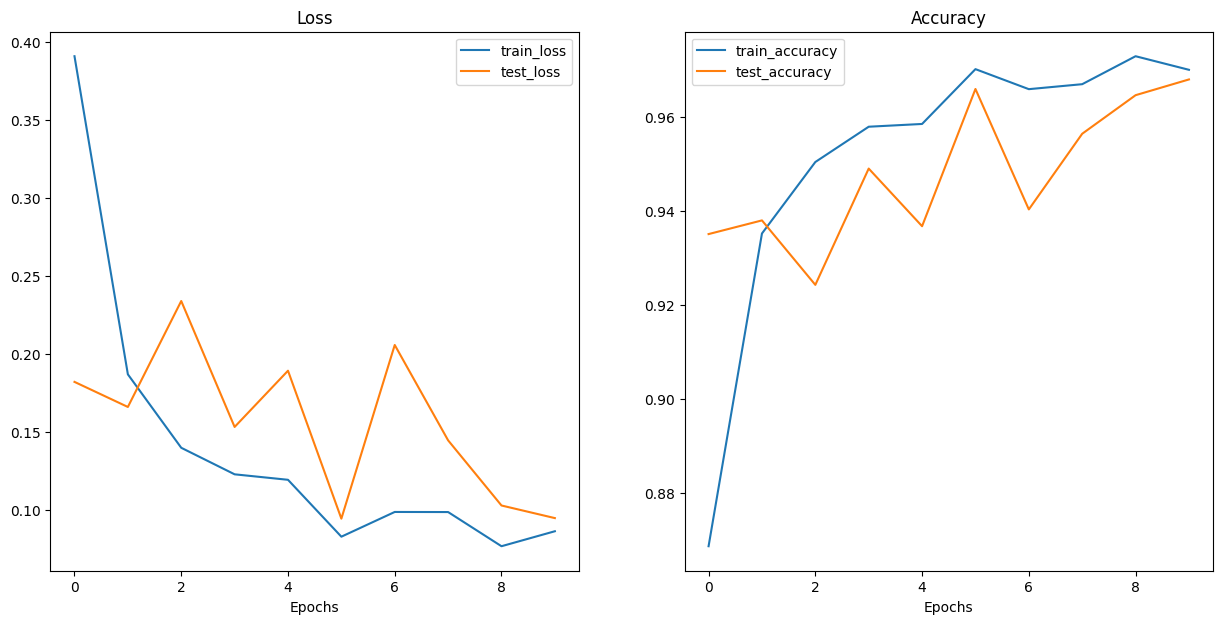

In [55]:
plot_loss_curves(history)

In [ ]:
!pip install torchmetrics

In [61]:
from torchmetrics import Accuracy

In [77]:
def evaluation(model : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               device : torch.device):
    # Eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for batch, (x_test,y_test) in enumerate(dataloader):
            x_test, y_test = x_test.to(device), y_test.to(device)

            # Forward pass
            test_pred = model(x_test)

            # loss
            loss = loss_fn(test_pred, y_test)
            test_loss += loss.item()

            # calculate accuracy
            test_pred_labels = test_pred.argmax(dim = 1)
            test_acc += (test_pred_labels == y_test).sum().item() / len(test_pred_labels)


    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    print(f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

In [75]:
evaluation(model = compiled_model,
           dataloader = test_dataloader,
           loss_fn = loss_fn,
           device = device)

test_loss: 0.0946 | test_acc: 0.9679
